# Example Fitting

In [1]:
# Enable inline plotting in notebook
%matplotlib inline
# Populate namespace with numerical python function library and matplotlib plotting library.
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec#
from scipy import interpolate

This notebook will run through the procedure for fitting lightcurves, using the mock lightcurves provided. First lets read in and plot the mock lightcurves. 

To read in the lightcurves: 
 - Each lightcurve is saved as a .dat file where each column is time, flux, flux_err. 
 - Specify the directory containing these files
 - The files are named: "ObjName"\_"filter"\.dat

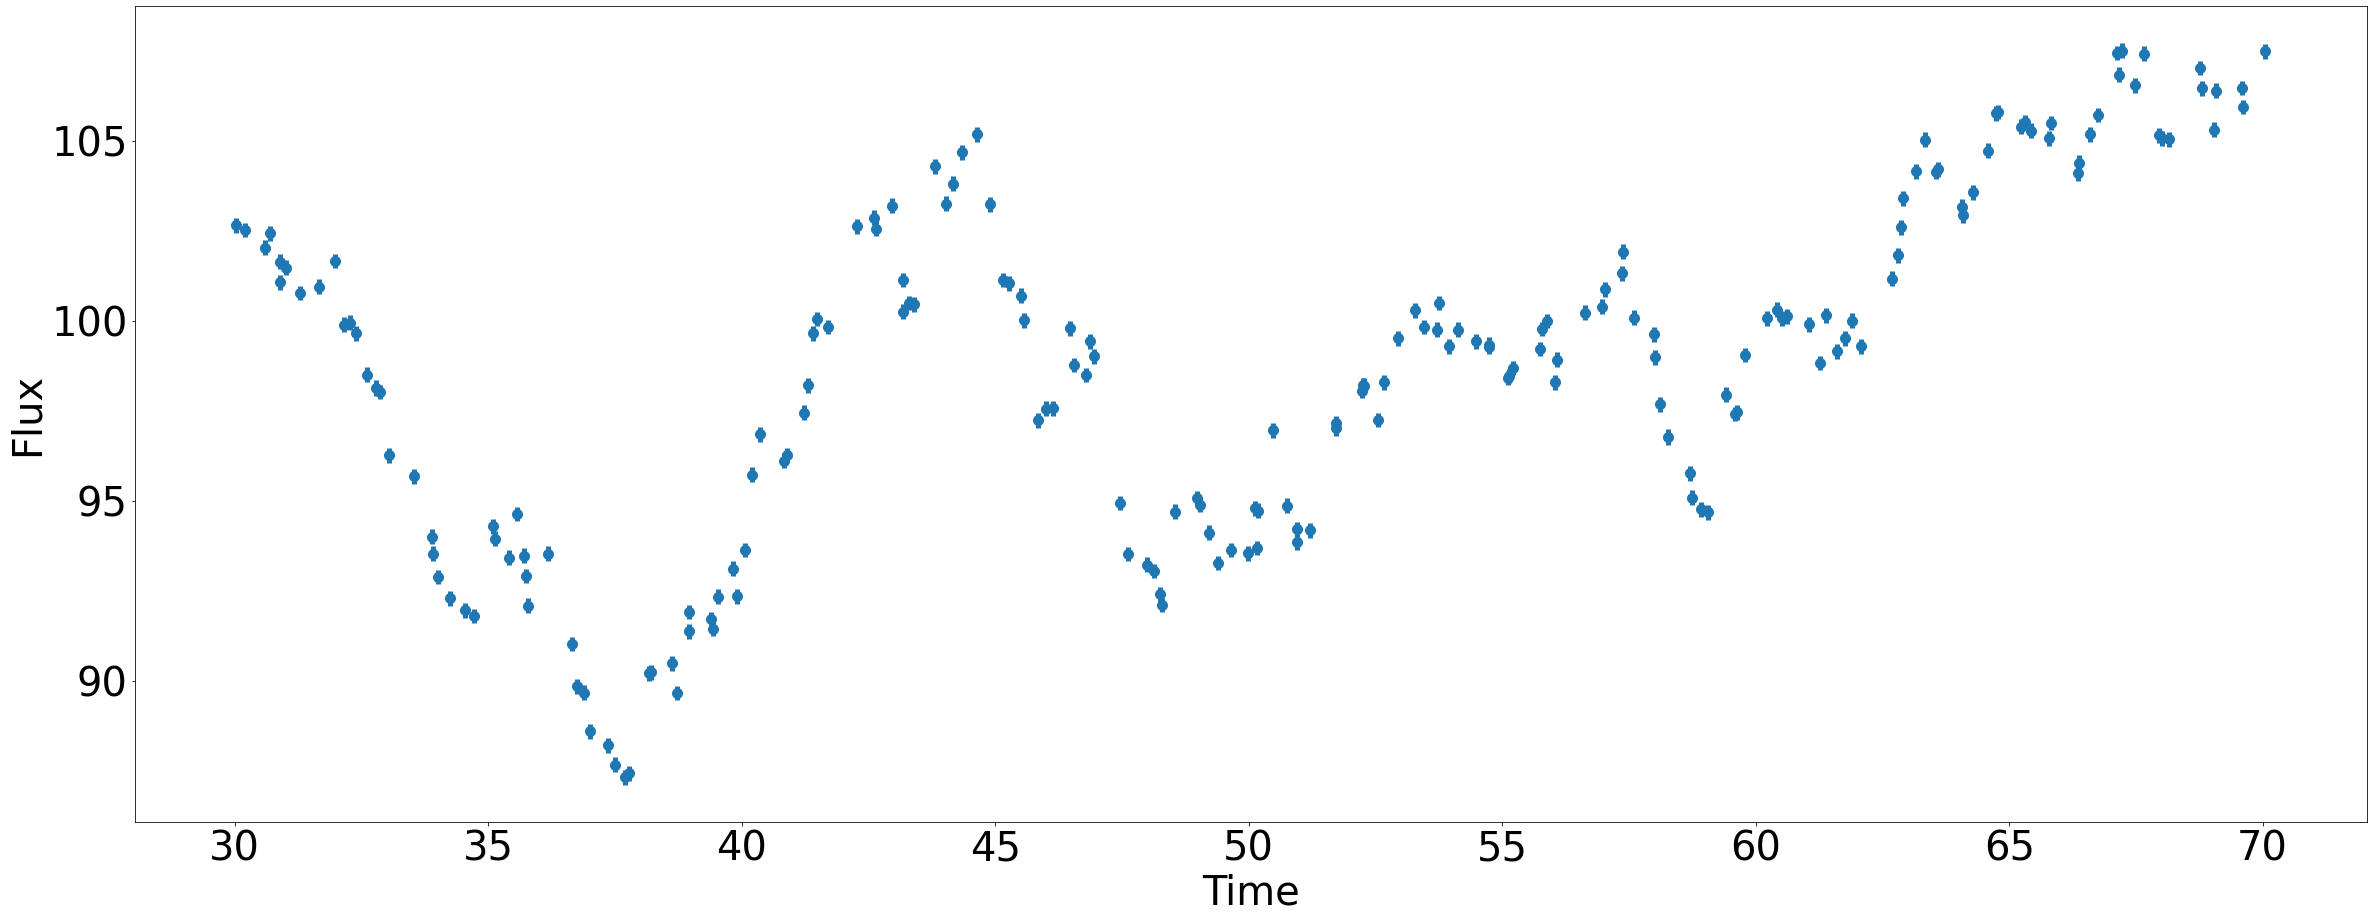

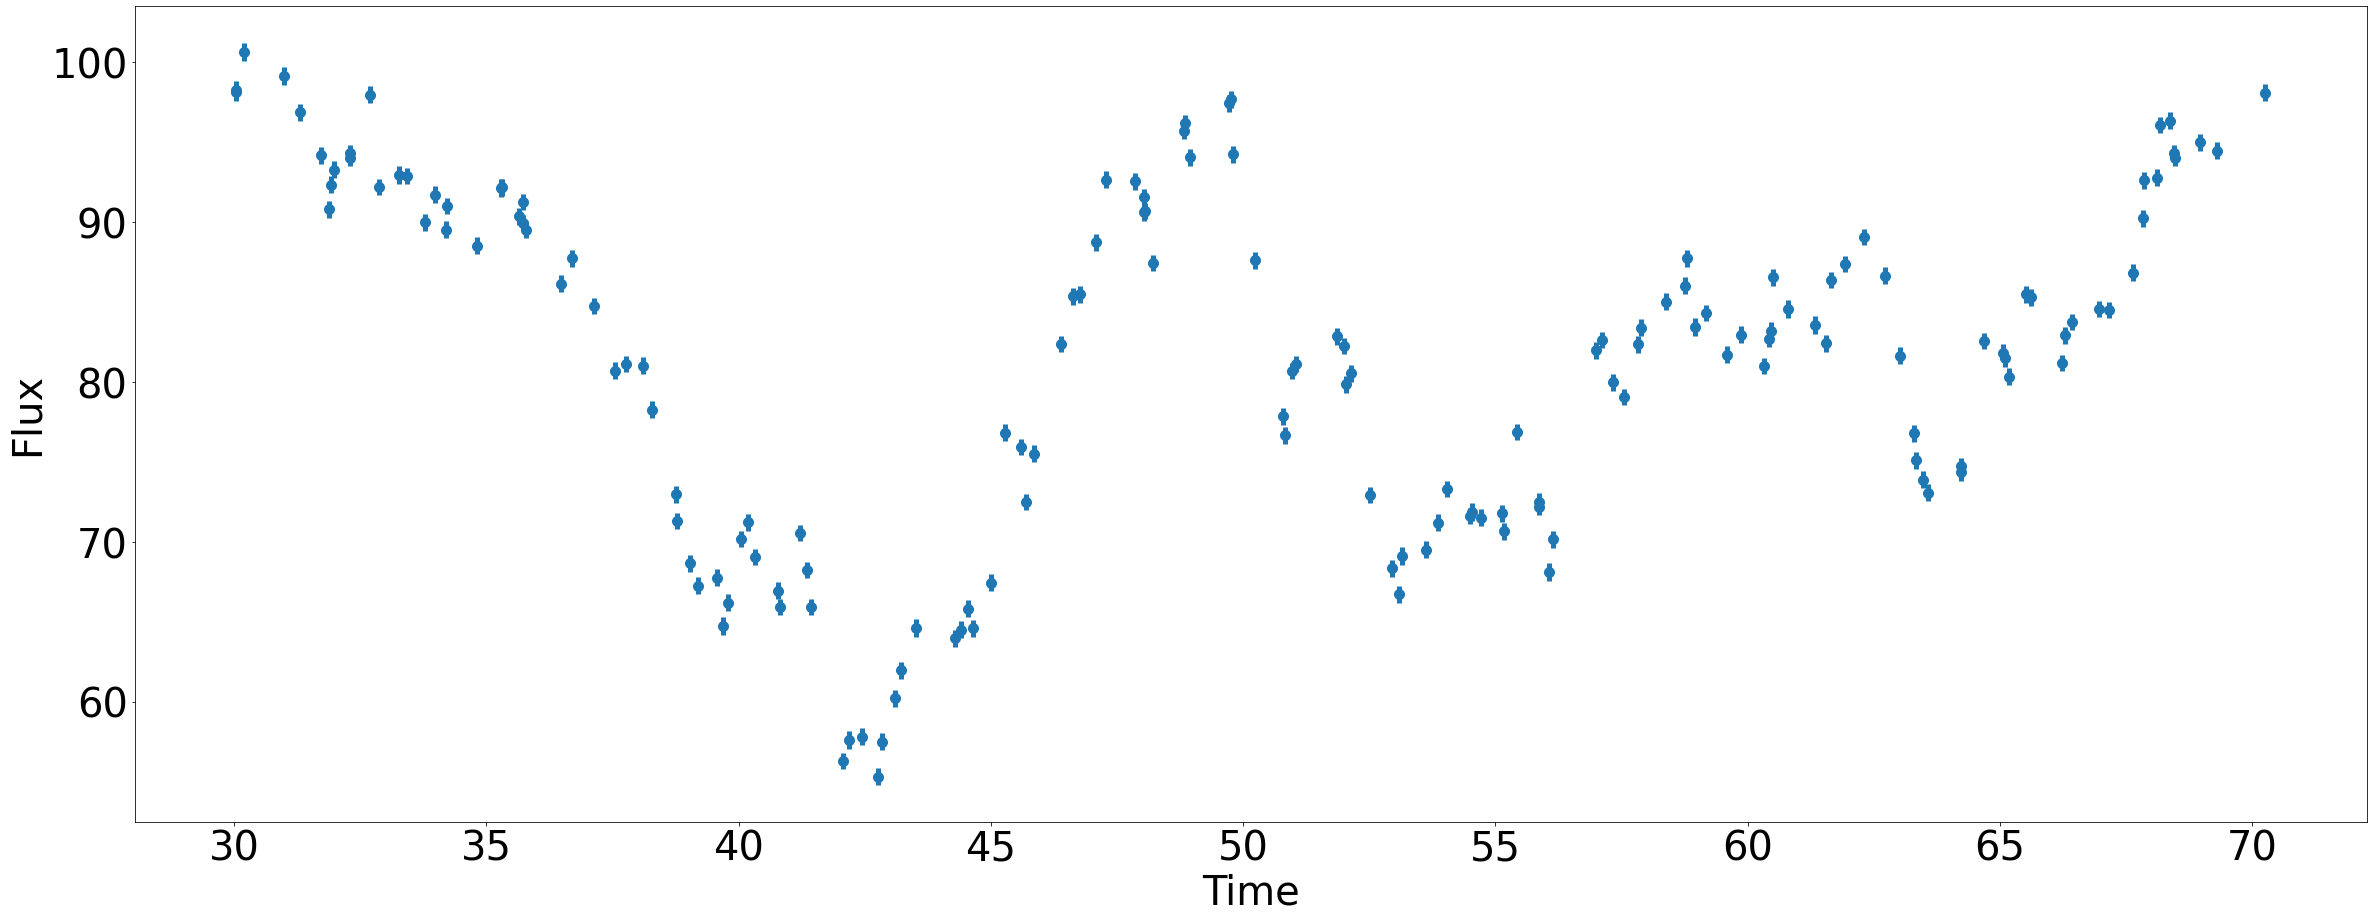

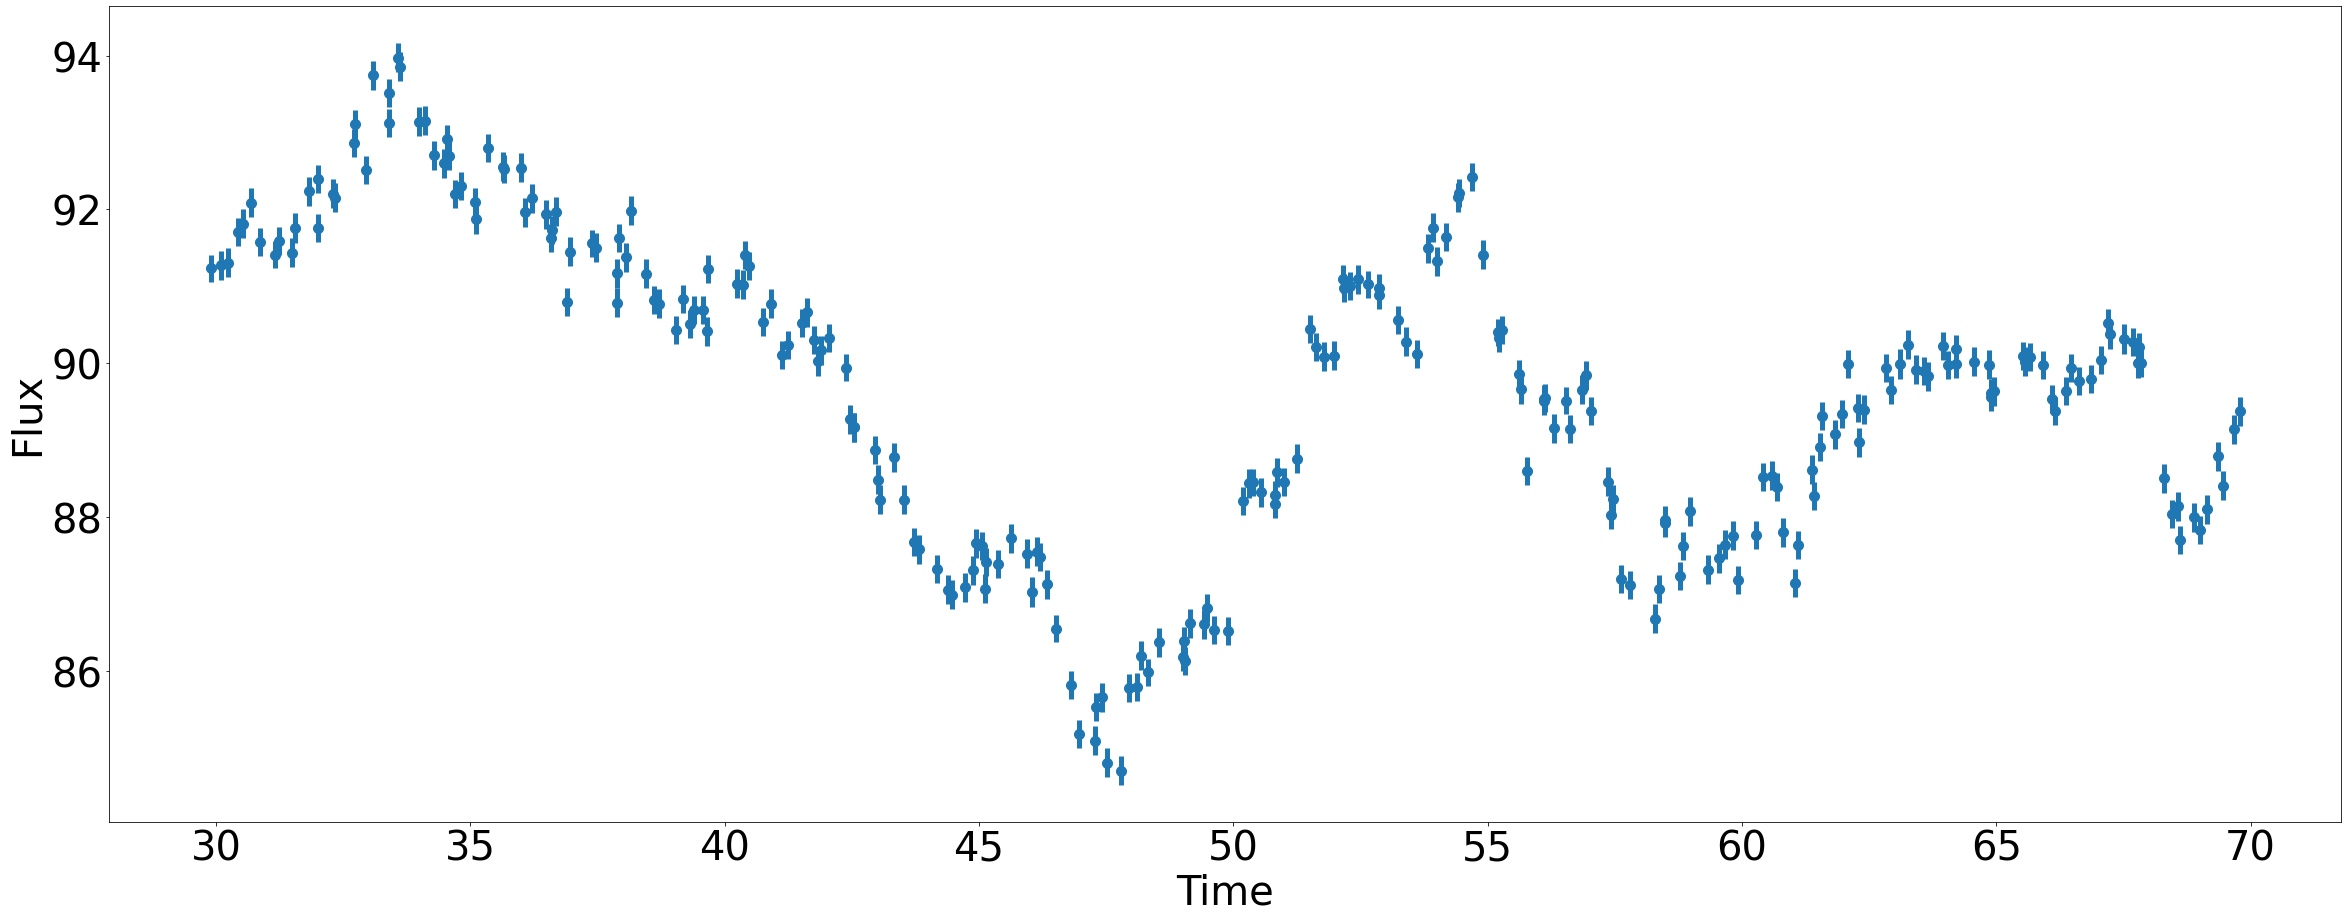

In [2]:
plt.style.use(['no-latex'])
plt.rcParams.update({
    "font.family": "Sans",  
    "font.serif": ["DejaVu"],
"figure.figsize":[40,15],
"font.size": 40})  




filters=["1","2","3"]
datadir = "/home/fergus/Documents/MPhysProj/GitHub/MockData/HighSN/"
data=[]
for i in range(len(filters)):
    file = datadir + "TestObj_" + str(filters[i]) + ".dat"
    data.append(np.loadtxt(file))
    mjd = data[i][:,0]
    flux = data[i][:,1]
    err = data[i][:,2]
    plt.figure(i)
    plt.errorbar(mjd, flux , yerr=err, ls='none', marker=".", ms=20, elinewidth=5)
    plt.ylabel("Flux")
    plt.xlabel("Time")


Next lets run the model fit. Again the lightcurves are stored in the format described above. To run the code, provide the directory of the lightcurves and the "ObjName" and "filters" of the lightcurves where each file is in the format "ObjName"\_"filter"\.dat

Priors are uniform where the limits must be specified in the following way:

priors = [[A_lower, A_upper], [B_lower, B_upper], [tau_lower, tau_upper],[delta_lower, delta_upper], [sig_lower, sig_upper]]

In [3]:
import PyROA
datadir = "/home/fergus/Documents/MPhysProj/GitHub/MockData/HighSN/"
objName="TestObj"
filters=["1","2","3"]
    
priors = [[0.0, 20.0],[0.0, 150.0], [-1.0, 50.0], [0.05, 5.0], [0.0, 10.0]]

fit = PyROA.Fit(datadir, objName, filters, priors, add_var=True) 


Initial Parameter Values
     A0       B0    σ0       A1       B1    τ1    σ1       A2       B2    τ2    σ2    Δ
-------  -------  ----  -------  -------  ----  ----  -------  -------  ----  ----  ---
4.77722  98.6747  0.01  10.7457  81.3551     0  0.01  1.98729  89.6344     0  0.01    1
NWalkers=26


100%|██████████| 10000/10000 [05:33<00:00, 29.96it/s]


Best Fit Parameters
     A0       B0        σ0      A1       B1       τ1       σ1       A2       B2       τ2        σ2         Δ
-------  -------  --------  ------  -------  -------  -------  -------  -------  -------  --------  --------
4.95488  99.9986  0.506725  12.038  85.1906  5.00361  1.31916  2.00266  90.0018  9.98816  0.193746  0.236879


The code will write some files to the local directory. These are
 - A corner plot
 - "samples.obj" - a pickle object containtnig the total unflattened samples
 - "samples_flat.obj" - a pickle object containing the flattened samples with the "burn-in" removed
 - "X_t.obj" - a pickle object containting the driving lightcurve. This is a list in the form [t, X, X_errs], where t is the time grid, X is the value of the driving lightcurve, and X_errs is the error envelope from the running optimal average. 
 - "Lightcurve_models.obj" - a pickle object containing the model for each lightcurve. This is a list of models where each model is an array with in the form [t, model, model_errs]. 
 
 
 These properties can also be recovered from the fit e.g fit.samples_flat will return the samples_flat array. Lets plot the results, loading in the pickle objects.

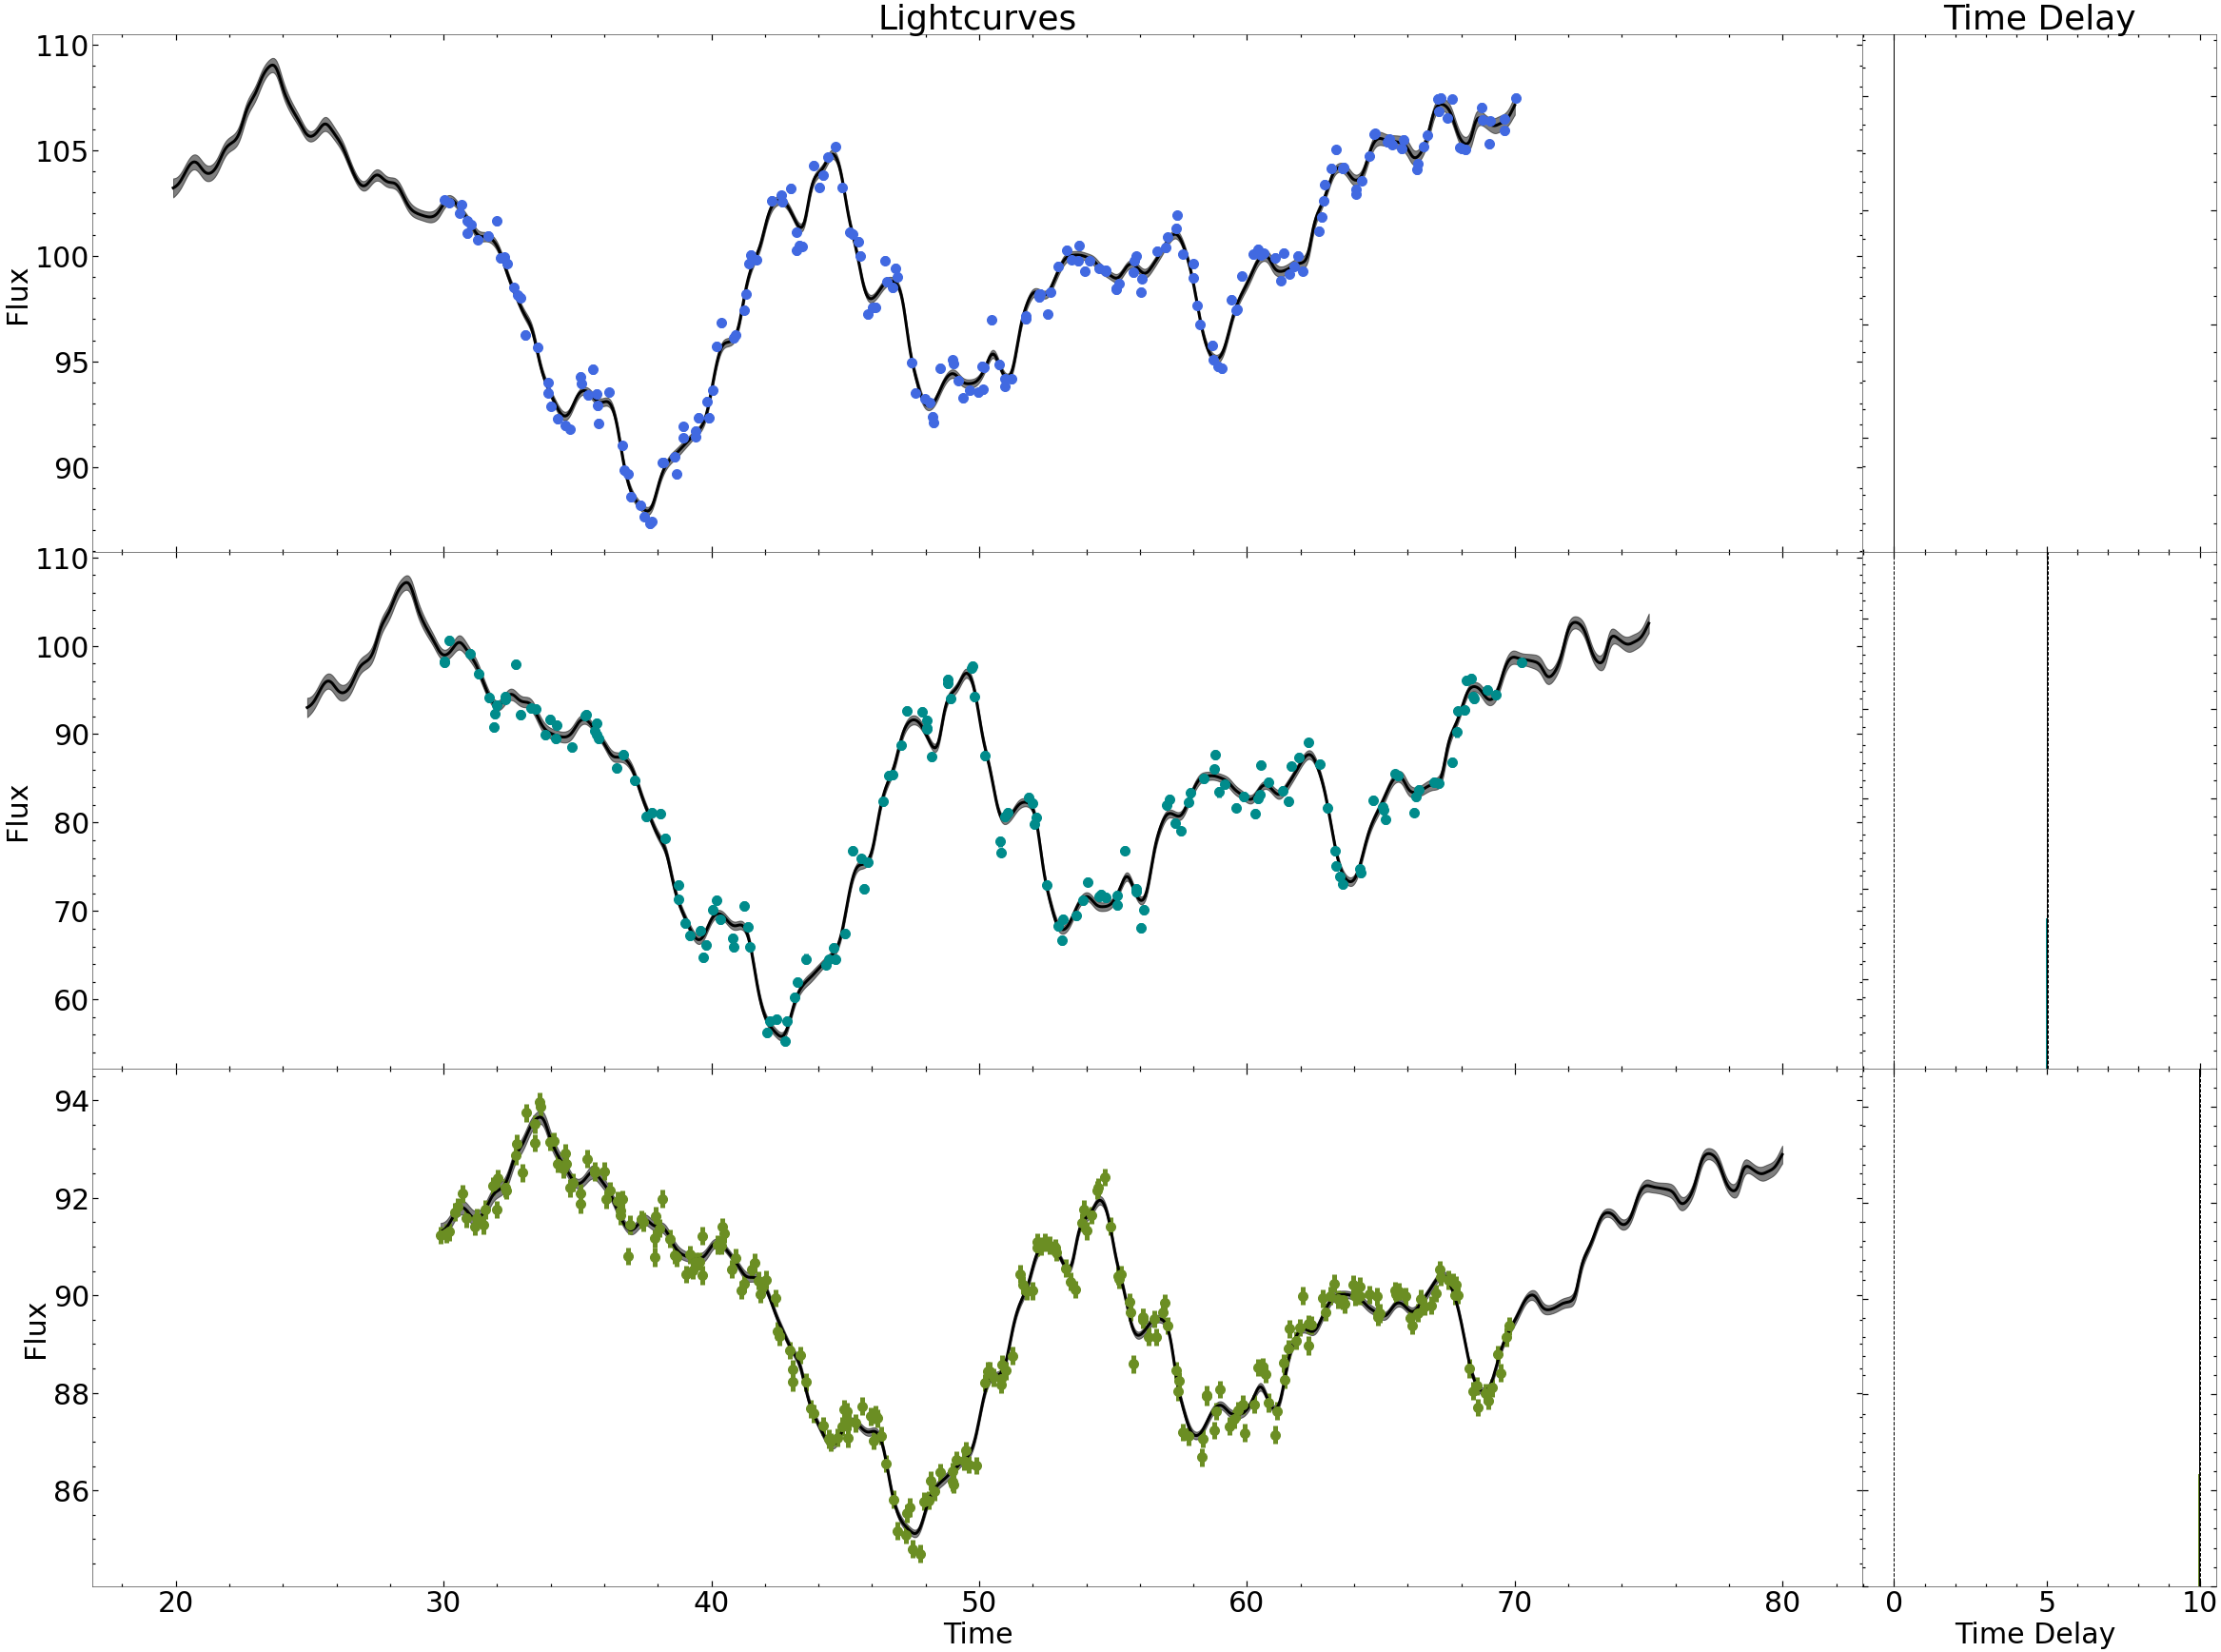

In [7]:
plt.rcParams.update({
    "font.family": "Sans",  
    "font.serif": ["DejaVu"],
"figure.figsize":[40,30],
"font.size": 30})  


import pickle
file = open("samples_flat.obj",'rb')
samples_flat = pickle.load(file)
file = open("Lightcurve_models.obj",'rb')
models = pickle.load(file)


#Split samples into chunks, 4 per lightcurve i.e A, B, tau, sig
chunk_size=4
transpose_samples = np.transpose(samples_flat)
#Insert zero where tau_0 would be 
transpose_samples = np.insert(transpose_samples, [2], np.array([0.0]*len(transpose_samples[1])), axis=0)
samples_chunks = [transpose_samples[i:i + chunk_size] for i in range(0, len(transpose_samples), chunk_size)] 



fig = plt.figure(5)
gs = fig.add_gridspec(len(filters), 2, hspace=0, wspace=0, width_ratios=[5, 1])
axs= gs.subplots(sharex='col')

band_colors=["royalblue", "darkcyan", "olivedrab", "#ff6f00", "#ef0000", "#610000"]

#Loop over lightcurves
filters=["1","2","3"]
datadir = "/home/fergus/Documents/MPhysProj/GitHub/MockData/HighSN/"
data=[]
for i in range(len(filters)):
    #Read in data
    file = datadir + "TestObj_" + str(filters[i]) + ".dat"
    data.append(np.loadtxt(file))
    mjd = data[i][:,0]
    flux = data[i][:,1]
    err = data[i][:,2]    
    
    #Plot Data
    axs[i][0].errorbar(mjd, flux , yerr=err, ls='none', marker=".", color=band_colors[i], ms=20, elinewidth=5)
    #Plot Model
    t, m, errs = models[i]
    axs[i][0].plot(t,m, color="black", lw=3)
    axs[i][0].fill_between(t, m+errs, m-errs, alpha=0.5, color="black")
    axs[i][0].set_xlabel("Time")
    axs[i][0].set_ylabel("Flux")

    #Plot Time delay posterior distributions
    tau_samples = samples_chunks[i][2],
    axs[i][1].hist(tau_samples, color=band_colors[i], bins=50)
    axs[i][1].axvline(x = np.percentile(tau_samples, [16, 50, 84])[1], color="black")
    axs[i][1].axvline(x = np.percentile(tau_samples, [16, 50, 84])[0] , color="black", ls="--")
    axs[i][1].axvline(x = np.percentile(tau_samples, [16, 50, 84])[2], color="black",ls="--")
    axs[i][1].axvline(x = 0, color="black",ls="--")    
    axs[i][1].set_xlabel("Time Delay ")
    axs[0][0].set_title("Lightcurves")
    axs[0][1].set_title("Time Delay")
for ax in axs.flat:
    ax.label_outer()    



The next plot is the driving lightcurve, $X(t)$, with the error envelope calculated from the running optimal average. Note that this is not due to any errors on any of the sampled parameters but rather the error in the optimal average at each point. 

Text(0.5, 1.0, 'Driving Lightcurve')

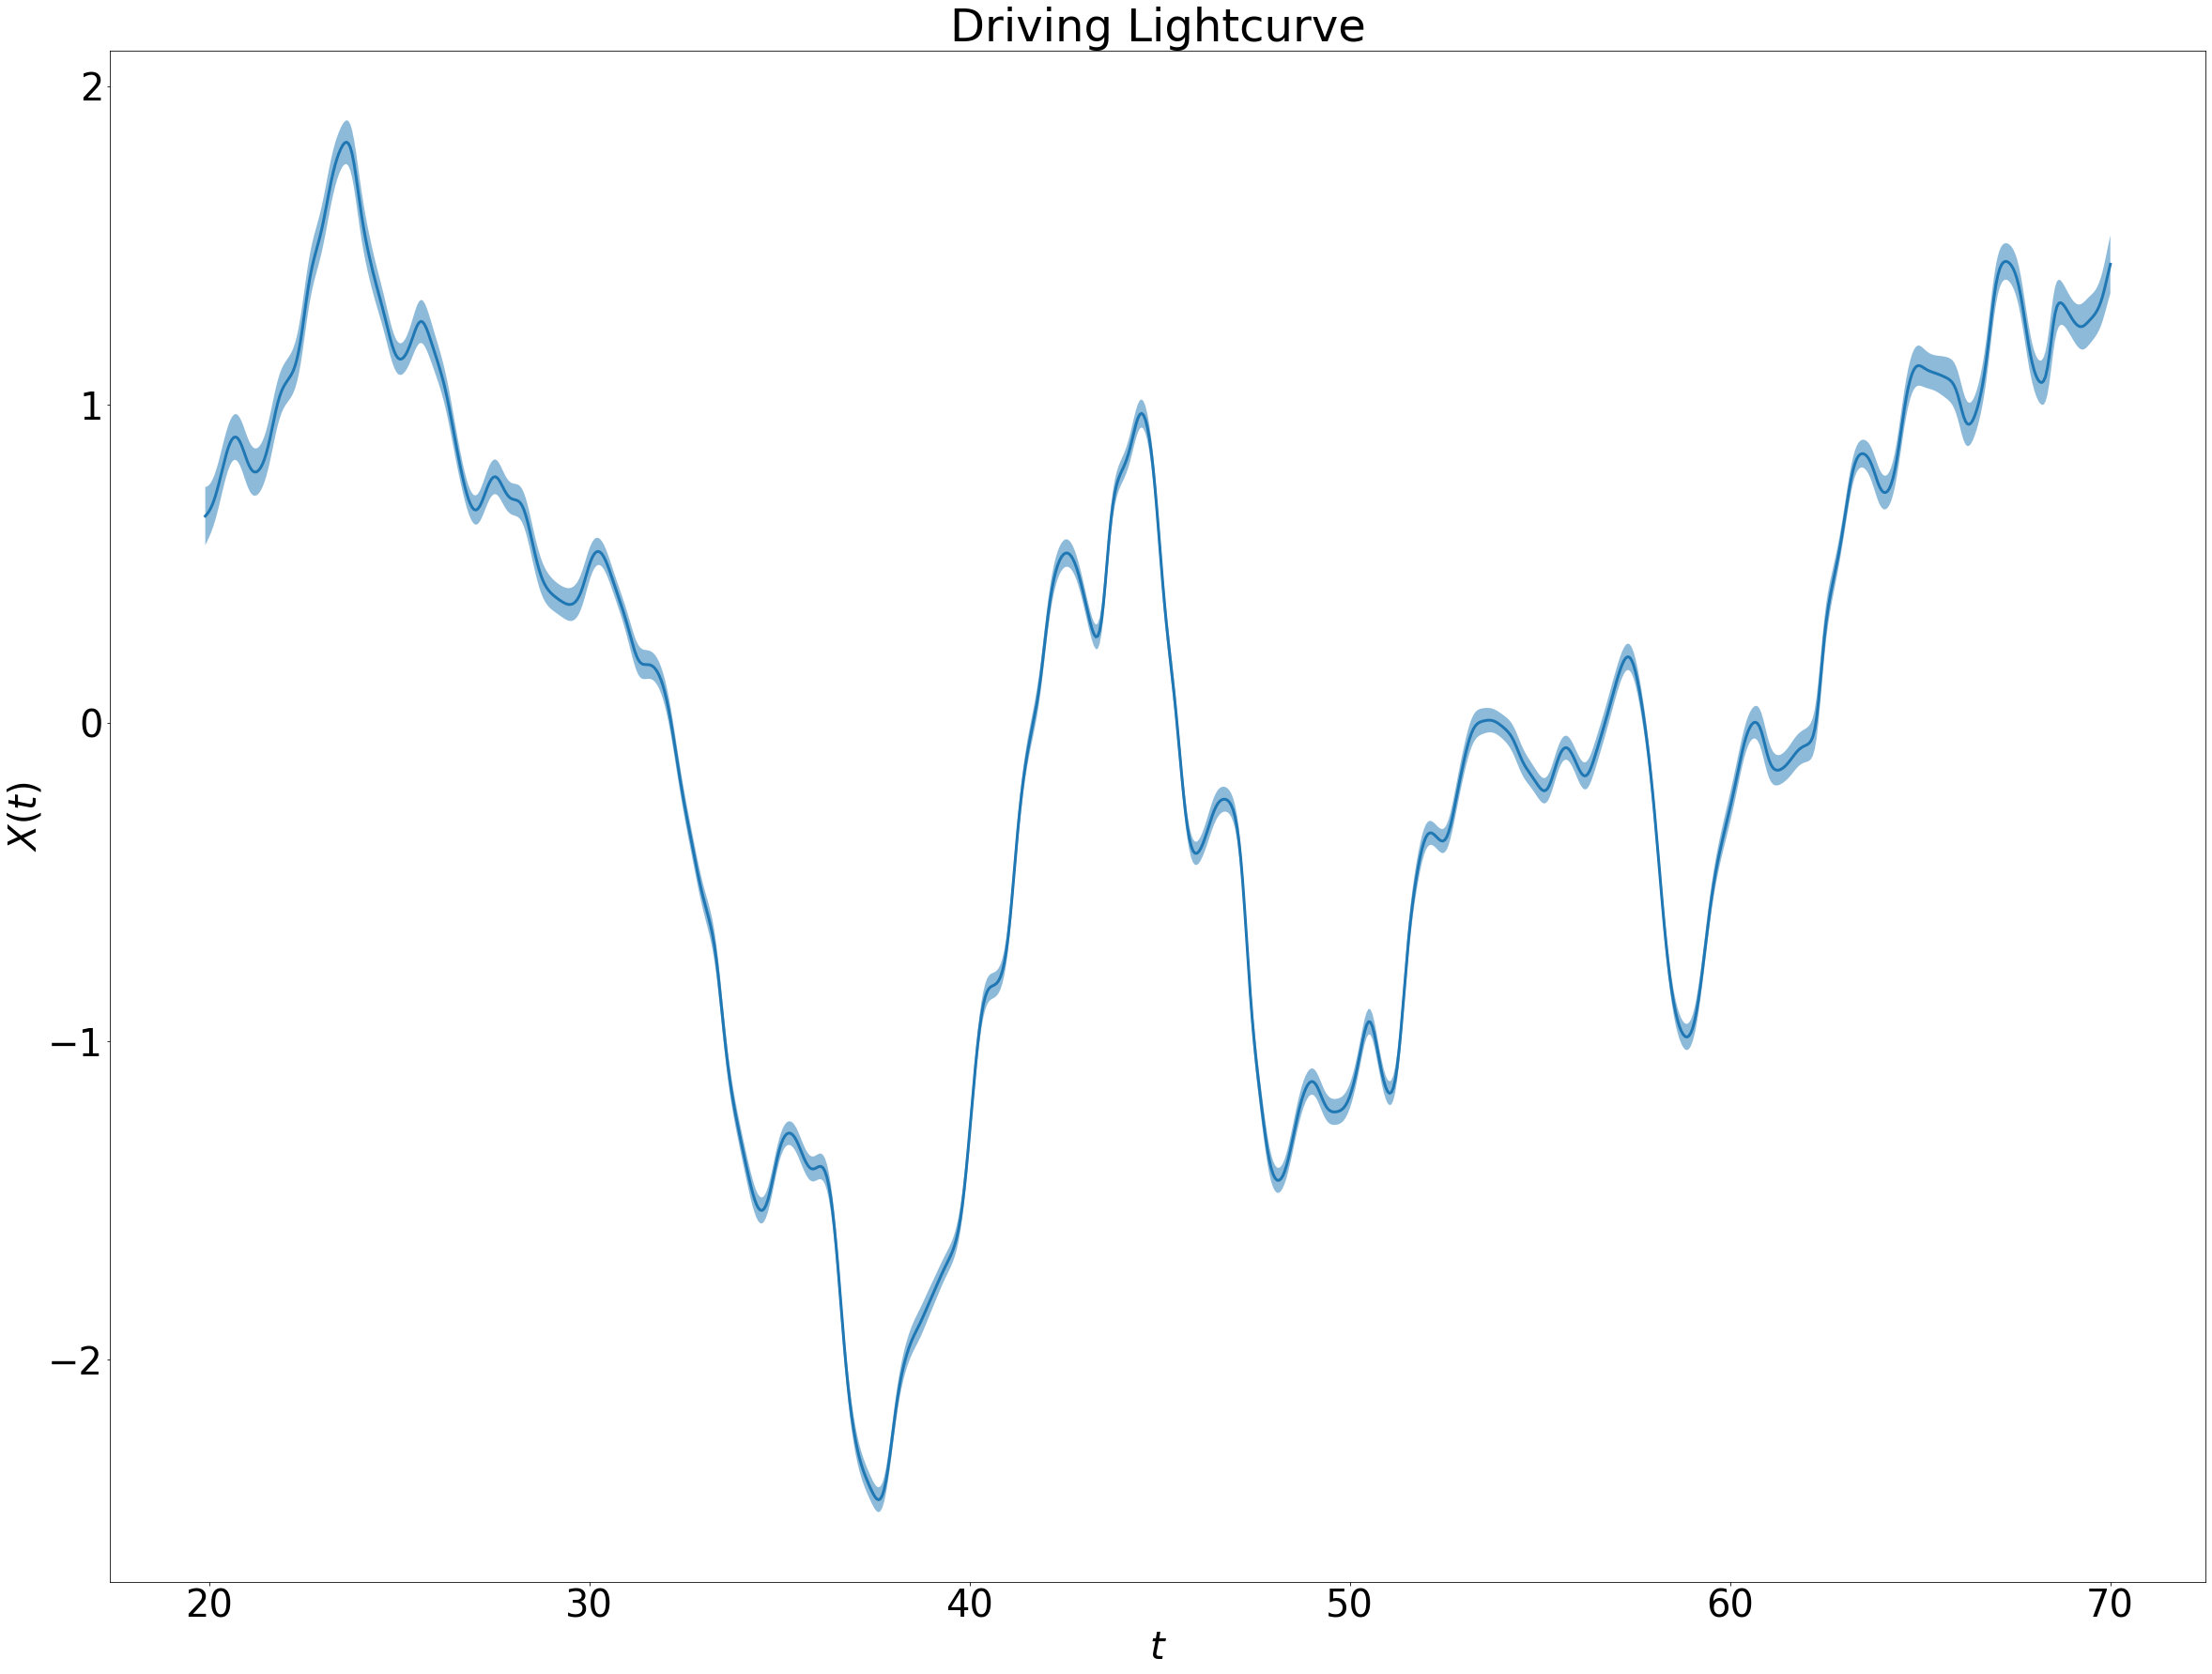

In [5]:
#Driving Lightcurve
plt.figure(6);
plt.rcParams.update({
    "figure.figsize":[40,15],
"font.size": 40}) 
plt.plot(fit.t, fit.X, lw=3);
plt.fill_between(fit.t, fit.X-fit.X_errs, fit.X+fit.X_errs, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel("$X(t)$")
plt.title("Driving Lightcurve")

We can also quickly get a plot using the function Plot.

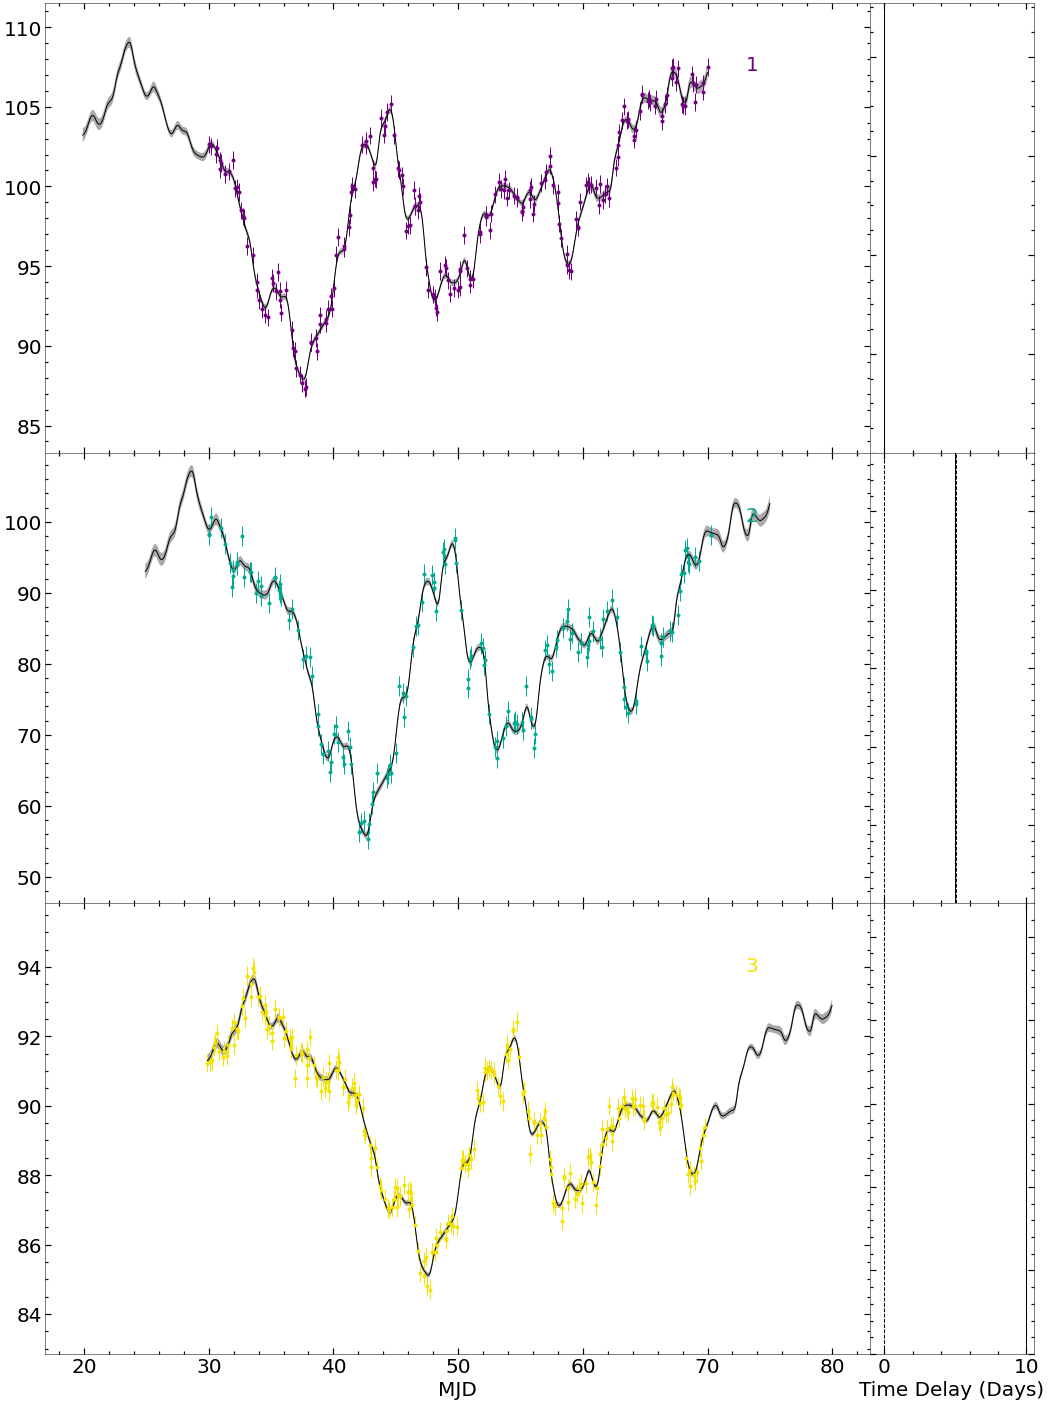

In [6]:
PyROA.Plot(fit)